In [74]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lecilab_behavior_analysis.df_transforms as dft
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import warnings
warnings.filterwarnings('ignore')


single mouse

In [42]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)
# download the data for a specific animal
mouse = "ACV002"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

['COT_test_data', 'visual_and_COT_data']
['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test', 'test2']
receiving incremental file list
ACV002.csv

sent 86,168 bytes  received 716,538 bytes  94,436.00 bytes/sec
total size is 155,766,222  speedup is 194.05


In [43]:
# reduce the dataset to the psychometric version of the task
# Otherwise, we would include a lot of "easy" trials that would bias the fit
df_test = df[df["current_training_stage"] == "TwoAFC_visual_hard"]

psychometric curve 

<Axes: xlabel='visual_stimulus_ratio', ylabel='left_choice'>

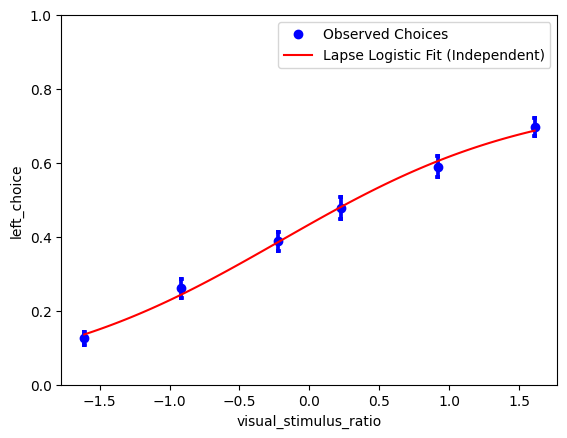

In [44]:
df_test = dft.get_performance_by_difficulty_ratio(df_test)
plots.psychometric_plot(df_test, x = 'visual_stimulus_ratio', y = 'left_choice')


<Axes: xlabel='visual_stimulus_diff_binned', ylabel='left_choice'>

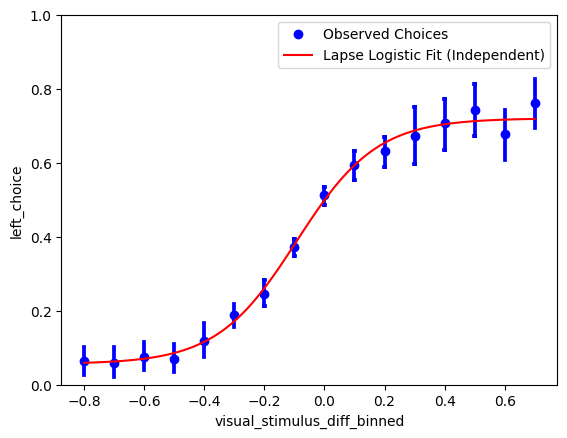

In [45]:
df_test = dft.get_performance_by_difficulty_diff(df_test)
plots.psychometric_plot(df_test, x = 'visual_stimulus_diff', y = 'left_choice', valueType = 'continue', )

GLM comparation

the following cell can be use to evaluate the model. It will be useful when comparing different models

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import numpy as np

# Define the lapse logistic function with independent lapses for left and right
def lapse_logistic_independent(params, x, y):
    lapse_left, lapse_right, beta, x0 = params
    # Ensure lapse rates are within [0, 0.5]
    lapse_left = np.clip(lapse_left, 0, 0.5)
    lapse_right = np.clip(lapse_right, 0, 0.5)
    # Predicted probabilities
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x - x0)))
    # Negative log-likelihood
    nll = -np.sum(y * np.log(p_left) + (1 - y) * np.log(1 - p_left))
    return nll

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
log_losses = []

# Perform cross-validation
for train_index, test_index in kf.split(df_test):
    # Split the data
    x_train, x_test = df_test['visual_stimulus_ratio'].values[train_index], df_test['visual_stimulus_ratio'].values[test_index]
    y_train, y_test = df_test['left_choice'].values[train_index], df_test['left_choice'].values[test_index]
    
    # Initial parameter guesses: [lapse_left, lapse_right, beta, x0]
    initial_params = [0.05, 0.05, 1, 0]
    
    # Fit the model on the training data
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x_train, y_train),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )
    
    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    
    # Generate predictions on the test data
    p_left_test = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x_test - x0)))
    
    # Calculate log loss for the test data
    loss = log_loss(y_test, p_left_test)
    log_losses.append(loss)

# Print cross-validation results
print(f"Cross-Validation Log Losses: {log_losses}")
print(f"Mean Log Loss: {np.mean(log_losses)}")
print(f"Standard ratio of Log Loss: {np.std(log_losses)}")

Cross-Validation Log Losses: [0.5956259610754516, 0.5965169299545352, 0.6129185367433484, 0.5938089695091081, 0.6020083675685833]
Mean Log Loss: 0.6001757529702053
Standard ratio of Log Loss: 0.006933405200063407


weight and stats for the different predictors:
- visual stimulus ratio (you call it deviation)
- visual stimulus diff. Nuo: change to "total intensity on left port"
- port where the animal is coming from
- interactions
- Nuo: add another regressor: the previous correct choice

We can play around with this things

In [85]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results, _ = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                      'previous_port_before_stimulus_numeric',
                      'visual_ratio_diff_interact',
                      'previous_choice_left_correct',
                      'previous_choice_right_wrong',
                      'previous_choice_left', 
                      'visual_ratio_bright_interact'
                          ], y = 'left_choice')
print(results)

Optimization terminated successfully.
         Current function value: 0.539326
         Iterations 7


TypeError: cannot unpack non-iterable Summary object

correct choice as output

In [48]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                                                    'wrong_bright', 
                                                    # 'wrong_bright_zscore',
                                                    'same_choice_correctPre', 
                                                    # 'diff_choice_wrongPre', 
                                                    'same_choice_previous', 
                                                    'previous_correct', 
                                                    # 'previous_choice_same_correct'
                                                    ], y = 'correct_numeric')
print(results) 

Optimization terminated successfully.
         Current function value: 0.602391
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7145
Model:                          Logit   Df Residuals:                     7139
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                 0.05523
Time:                        16:58:59   Log-Likelihood:                -4304.1
converged:                       True   LL-Null:                       -4555.7
Covariance Type:            nonrobust   LLR p-value:                1.592e-106
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    -0.5437      0.091     -5.960      0.000      -0.

auditory

In [49]:
df_auditory = df[df["current_training_stage"] == "TwoAFC_auditory_hard"]

In [50]:
df_auditory

,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,correct,correct_side,current_training_stage,difficulty,holding_time,ordered_list_of_events,stimulus_modality,stimulus_modality_block_number,visual_stimulus,water
51433,244.0,2025-06-15 04:47:36,1.0,ACV002,TwoAFC,village01,Auto,"[1749959285.535432, 1749959287.046632]",[1749959285.914232],"[1749959282.959032, 1749959284.756432, 1749959...",...,True,left,TwoAFC_auditory_hard,hard,0.5,"['Tup', 'Port2In', 'Tup', 'Port2Out', 'Port3In...",auditory,NaN,NaN,2.0
51434,244.0,2025-06-15 04:47:36,2.0,ACV002,TwoAFC,village01,Auto,NaN,[1749959288.7603002],[1749959289.0537],...,True,right,TwoAFC_auditory_hard,easy,0.5,"['Tup', 'Port1Out', 'Port2In', 'Tup', 'Tup', '...",auditory,NaN,NaN,2.0
51435,244.0,2025-06-15 04:47:36,3.0,ACV002,TwoAFC,village01,Auto,"[1749959294.6285741, 1749959295.129074, 174995...","[1749959295.110074, 1749959295.221574, 1749959...","[1749959293.8555741, 1749959295.518074, 174995...",...,True,left,TwoAFC_auditory_hard,hard,0.5,"['Tup', 'Port3Out', 'Port2In', 'Tup', 'Port2Ou...",auditory,NaN,NaN,2.0
51436,244.0,2025-06-15 04:47:36,4.0,ACV002,TwoAFC,village01,Auto,"[1749959299.425524, 1749959300.785624]","[1749959299.756224, 1749959301.068624]","[1749959298.539824, 1749959300.023324]",...,False,right,TwoAFC_auditory_hard,hard,0.5,"['Tup', 'Port3In', 'Port3Out', 'Port2In', 'Tup...",auditory,NaN,NaN,0.0
51437,244.0,2025-06-15 04:47:36,5.0,ACV002,TwoAFC,village01,Auto,"[1749959307.611062, 1749959308.957862]","[1749959307.821862, 1749959310.114462]","[1749959306.962062, 1749959308.1925619, 174995...",...,True,right,TwoAFC_auditory_hard,hard,0.5,"['Tup', 'Port2In', 'Tup', 'Port2Out', 'Port1In...",auditory,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56628,263.0,2025-06-19 21:18:59,452.0,ACV002,TwoAFC,village01,Auto,"[1750365973.620096, 1750365976.329496]","[1750365972.546896, 1750365973.844996, 1750365...","[1750365972.869696, 1750365974.109296, 1750365...",...,True,right,TwoAFC_auditory_hard,hard,0.5,"['Tup', 'Port1Out', 'Port2In', 'Tup', 'Port2Ou...",auditory,NaN,NaN,2.0
56629,263.0,2025-06-19 21:18:59,453.0,ACV002,TwoAFC,village01,Auto,NaN,NaN,[1750365979.704152],...,True,right,TwoAFC_auditory_hard,medium,0.5,"['Tup', 'Port3Out', 'Port2In', 'Tup', 'Tup', '...",auditory,NaN,NaN,2.0
56630,263.0,2025-06-19 21:18:59,454.0,ACV002,TwoAFC,village01,Auto,[1750365986.033325],[1750365986.3013248],"[1750365982.444725, 1750365983.512425, 1750365...",...,False,left,TwoAFC_auditory_hard,medium,0.5,"['Tup', 'Port3Out', 'Port3In', 'Port3Out', 'Po...",auditory,NaN,NaN,0.0
56631,263.0,2025-06-19 21:18:59,455.0,ACV002,TwoAFC,village01,Auto,NaN,NaN,[1750365986.562243],...,True,right,TwoAFC_auditory_hard,easy,0.5,"['Tup', 'Port2In', 'Tup', 'Tup', 'Port2Out', '...",auditory,NaN,NaN,2.0


Correct wrong psychometric curve

KeyError: 'previous_choice'

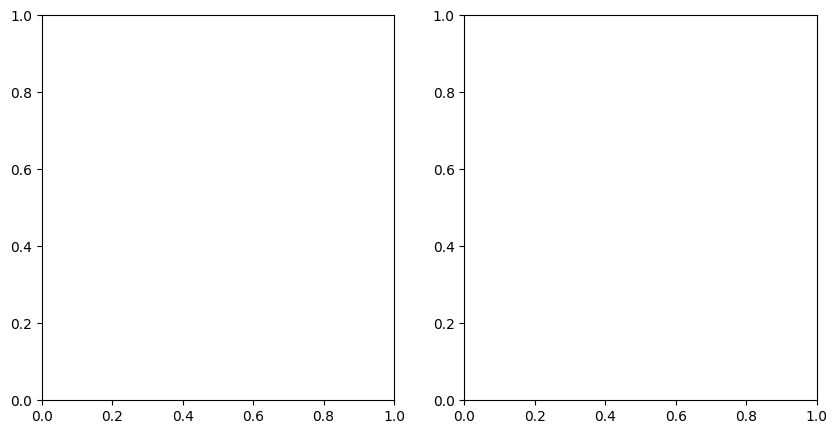

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test[df_test['previous_choice'] == 'left'].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[0],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )

for i, linecolor in zip(df_test[df_test['previous_choice'] == 'right'].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[1],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )
ax[0].legend()
ax[0].set_title("Left Choice Previous")
ax[1].legend()
ax[1].set_title("Right Choice Previous")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test[df_test['previous_correct'] == True].groupby('previous_choice'), ['gold', 'lightskyblue']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[0],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )

for i, linecolor in zip(df_test[df_test['previous_correct'] == False].groupby('previous_choice'), ['gold', 'lightskyblue']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[1],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )
ax[0].legend()
ax[0].set_title("Correct Choice Previous")
ax[1].legend()
ax[1].set_title("Incorrect Choice Previous")

Matrix format

In [ ]:
# let's use the absolute value of the lowest visual stimulus as a proxy for the brightness of the visual stimulus
df_test['visual_stimulus_lowest'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0]) if eval(x)[0] < eval(x)[1] else abs(eval(x)[1]))
# create 10 bins for the absolute value of the lowest visual stimulus
min_value = df_test['visual_stimulus_lowest'].min()
max_value = df_test['visual_stimulus_lowest'].max()
bins = np.linspace(min_value, max_value, 11)
df_test['visual_stimulus_lowest_binned'] = pd.cut(df_test['visual_stimulus_lowest'], bins=bins, labels=[f"{b:.2f}" for b in bins[:-1]])
# create a pivot table with the visual stimulus ratio and absolute value of the lowest visual stimulus
pivot_table_abs = df_test.pivot_table(
    index='visual_stimulus_lowest_binned',
    columns='visual_stimulus_ratio',
    values='left_choice',
    aggfunc='mean',
    observed=True
)
# plot the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(pivot_table_abs, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'})
plt.xlabel("Visual Stimulus ratio")
plt.ylabel("Absolute Value of Lowest Visual Stimulus")
plt.title("Heatmap of Probability of Left Choice")
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# transform visual_stimulus_lowest_binned to a numeric value for plotting
df_test['visual_stimulus_lowest_binned_num'] = pd.to_numeric(df_test['visual_stimulus_lowest_binned'], errors='coerce')

# make two plots, one for when the animals comes from the left and one for when it comes from the right
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Plot for when the animal comes from the left
for ax, side in zip(axs.ravel(), ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    for i in df_side.groupby('visual_stimulus_ratio'):
        df_i = i[1].sort_values(by='visual_stimulus_lowest_binned_num')
        # drop nan
        df_i = df_i.dropna(subset=['visual_stimulus_lowest_binned_num'])
        X = df_i['visual_stimulus_lowest_binned_num'].values.reshape(-1, 1)
        y = df_i['left_choice'].values.astype(int)
        model = LogisticRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1]
        ax.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    ax.set_xlabel("Absolute Value of Lowest Visual Stimulus")
    ax.set_ylabel("Probability of Left Choice")
    ax.legend()
    ax.set_title(f"Last Choice Before Stimulus: {side.capitalize()}")
plt.show()

Fit the lapse model independently considering previous choices

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

colors = ["blue", "orange"]

for color, side in zip(colors, ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    # Fit the model
    x = df_side['visual_stimulus_ratio'].values
    y = df_side['left_choice'].values
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x, y),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )

    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    print(f"Side: {side}, Lapse Left: {lapse_left}, Lapse Right: {lapse_right}, Slope (Beta): {beta}, PSE (x0): {x0}")

    # Generate predictions
    xs = np.linspace(df_side['visual_stimulus_ratio'].min(), df_side['visual_stimulus_ratio'].max(), 100)
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (xs - x0)))

    # Plot the fitted curve

    sns.pointplot(
        x='visual_stimulus_ratio',
        y='left_choice',
        data=df_side,
        estimator=lambda x: np.mean(x),
        color=color,
        markers='o',
        errorbar=("ci", 95),
        ax=ax,
        label=f'Choices when coming from {side}',
        native_scale=True,
        linestyles='',
    )
    ax.plot(xs, p_left, color=color, label='Lapse Logistic Fit')
    ax.set_xlabel("Visual Stimulus ratio")
    ax.set_ylabel("Probability of Left Choice")
    plt.title(f"Psychometric Curves")
    ax.legend()
plt.show()

I kept what you did for comparison here

In [ ]:
# It is interesting to compare the effects of the relative difference between the two visual stimuli,
# and the absolute difference between them.

# Maybe what we can do is to train another logistic regression model, adding as well the absolute difference
# between the two visual stimuli, and see how it affects the probability of a left choice.
# Do you know what I mean?

for i in df_test.groupby('visual_stimulus_ratio'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")
plt.show()

Multiple animals analysis


In [22]:
df_dic = {}
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )
    # load the data
    df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

receiving incremental file list
ACV001.csv

sent 85,510 bytes  received 1,368,366 bytes  126,424.00 bytes/sec
total size is 157,956,253  speedup is 108.64


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list

sent 20 bytes  received 69 bytes  35.60 bytes/sec
total size is 151,271,301  speedup is 1,699,677.54


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV003.csv

sent 79,259 bytes  received 1,794,061 bytes  220,390.59 bytes/sec
total size is 139,605,563  speedup is 74.52


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV004.csv

sent 68,549 bytes  received 847,554 bytes  140,938.92 bytes/sec
total size is 101,082,771  speedup is 110.34


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV005.csv

sent 67,877 bytes  received 887,523 bytes  146,984.62 bytes/sec
total size is 99,306,586  speedup is 103.94


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV006.csv

sent 71,146 bytes  received 2,438,181 bytes  295,214.94 bytes/sec
total size is 119,109,180  speedup is 47.47


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list

sent 20 bytes  received 69 bytes  59.33 bytes/sec
total size is 100,654,983  speedup is 1,130,954.87


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV008.csv

sent 82,374 bytes  received 22,737,109 bytes  2,402,050.84 bytes/sec
total size is 154,542,813  speedup is 6.77


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV009.csv

sent 83,312 bytes  received 2,325,317 bytes  283,368.12 bytes/sec
total size is 156,189,501  speedup is 64.85


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV010.csv

sent 77,964 bytes  received 1,654,300 bytes  203,795.76 bytes/sec
total size is 136,232,320  speedup is 78.64


/tmp/ipykernel_15060/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list

sent 20 bytes  received 71 bytes  36.40 bytes/sec
total size is 409,338  speedup is 4,498.22
receiving incremental file list

sent 20 bytes  received 72 bytes  61.33 bytes/sec
total size is 7,152  speedup is 77.74


In [53]:
df_dic_hard = {}
for df_name, df in zip(df_dic.keys(), df_dic.values()):
    if 'TwoAFC_visual_hard' in df["current_training_stage"].unique():
        df = df[df["current_training_stage"] == "TwoAFC_visual_hard"]
        df = dft.get_performance_by_difficulty_ratio(df)
        df = dft.get_performance_by_difficulty_diff(df)
        df_dic_hard[df_name] = df

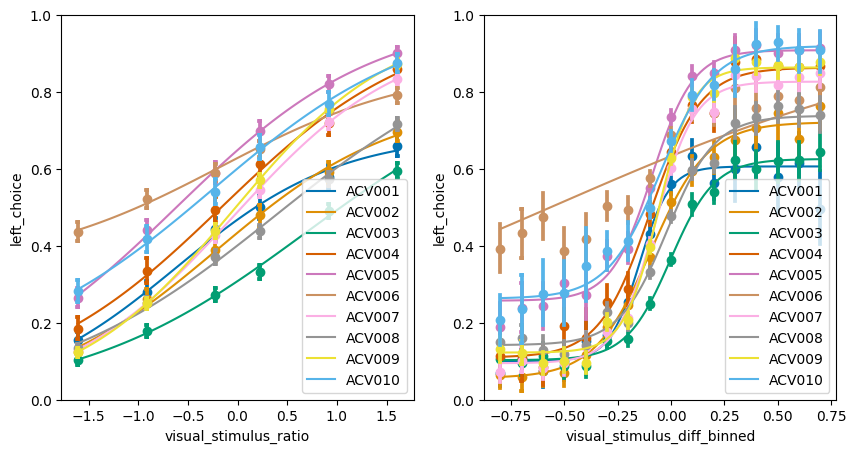

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    df = df_dic_hard[df_name]
    plots.psychometric_plot(df, x='visual_stimulus_ratio', y='left_choice', ax = ax[0], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': df_name})
    plots.psychometric_plot(df, x='visual_stimulus_diff', y='left_choice', ax = ax[1], point_kwargs={'color': color, 'label' : ''}, line_kwargs={'color': color, 'label': df_name}, valueType='continue')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
X = ['abs_visual_stimulus_ratio',
    'previous_port_before_stimulus_numeric',
    'visual_ratio_diff_interact',
    'previous_choice_left_correct',
    'previous_choice_right_wrong',
    'previous_choice_left', 
    'visual_ratio_bright_interact'
    ]
df_leftChoice_model_p = pd.DataFrame()
df_leftChoice_model_coef = pd.DataFrame()
df_leftChoice_model_z =  pd.DataFrame()
for df_name, df, color in zip(df_dic_hard.keys(), df_dic_hard.values(), sns.color_palette("colorblind", len(df_dic_hard))):
    df = df_dic_hard[df_name]
    df_for_fit = dft.parameters_for_fit(df)
    # normalize the X columns in the df_for_fit by zscore
    df_for_fit[X] = df_for_fit[X].apply(lambda x: (x - x.mean()) / x.std())
    _, model = utils.logi_model_fit(df_for_fit, X=X, y='left_choice')
    # plot the results
    df_leftChoice_model_p[df_name] = model.pvalues
    ax[0].barplot(X, model.pvalues, color=color, label=df_name)
    df_leftChoice_model_coef[df_name] = model.params
    ax[1].barplot(X, model.params, color=color, label=df_name)
    df_leftChoice_model_z[df_name] = model.tvalues
    ax[2].barplot(X, model.tvalues, color=color, label=df_name)

In [ ]:
df_ratio_diffBin_inter_p = pd.DataFrame()
df_ratio_diffBin_inter_coef = pd.DataFrame()
for df_name, df in zip(df_dic_hard.keys(), df_dic_hard.values()):
    df['interaction_term'] = df.apply(interaction_calc, axis=1)
    # Prepare the independent variables
    X_multi = df[['visual_stimulus_ratio', 'visual_stimulus_diff_binned', 'interaction_term']]
    X_multi_const = sm.add_constant(X_multi)
    y = df['left_choice'].values.astype(int)

    # Fit the logistic regression model with multiple regressors
    logit_model_multi = sm.Logit(y, X_multi_const).fit()

    df_ratio_diffBin_inter_p[df_name] = logit_model_multi.pvalues
    df_ratio_diffBin_inter_coef[df_name] = logit_model_multi.params

In [ ]:
df_ratio_diff_inter_p = pd.DataFrame()
df_ratio_diff_inter_coef = pd.DataFrame()
for df_name, df in zip(df_dic_hard.keys(), df_dic_hard.values()):
    df['interaction_term'] = df.apply(interaction_calc, axis=1)
    # Prepare the independent variables
    X_multi = df[['visual_stimulus_ratio', 'visual_stimulus_diff', 'interaction_term']]
    X_multi_const = sm.add_constant(X_multi)
    y = df['left_choice'].values.astype(int)

    # Fit the logistic regression model with multiple regressors
    logit_model_multi = sm.Logit(y, X_multi_const).fit()

    df_ratio_diff_inter_p[df_name] = logit_model_multi.pvalues
    df_ratio_diff_inter_coef[df_name] = logit_model_multi.params

In [67]:
print(sns.color_palette("colorblind", len(df_dic_hard)))

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


In [ ]:
df_ratio_diffBin_inter_p.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff_binned': 'diff', 'interaction_term': 'inter'}, inplace=True)
df_ratio_diff_inter_p.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff': 'diff', 'interaction_term': 'inter'}, inplace=True)
for df_name, color in zip(df_dic_hard.keys(), sns.color_palette("colorblind", len(df_dic_hard))):
    plt.plot (df_ratio_diff_inter_p[df_name], label=df_name+ 'ratio_diff_inter', color=color)
    plt.plot (df_ratio_diffBin_inter_p[df_name], label=df_name+ 'ratio_diffBin_inter', color=color, linestyle='--')
plt.axhline(y=0.05, color='k', linestyle='--', label='p-value threshold')
plt.xlabel("Regressors")
plt.ylabel("p-value")
plt.legend(loc = (1 , 0))

In [ ]:
df_ratio_diffBin_inter_coef.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff_binned': 'diff', 'interaction_term': 'inter'}, inplace=True)
df_ratio_diff_inter_coef.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff': 'diff', 'interaction_term': 'inter'}, inplace=True)
for df_name, color in zip(df_dic_hard.keys(), sns.color_palette("colorblind", len(df_dic_hard))):
    plt.plot (df_ratio_diff_inter_coef[df_name], label=df_name+ 'ratio_diff_inter', color=color)
    plt.plot (df_ratio_diffBin_inter_coef[df_name], label=df_name+ 'ratio_diffBin_inter', color=color, linestyle='--')
plt.xlabel("Regressors")
plt.ylabel("Coefficient")
plt.legend(loc = (1 , 0))